In [1]:
#!pip install powerlaw
import pandas as pd
import glob
import numpy as np
import pickle
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw
import math
import operator

In [2]:
unique_subreddits_path =r"cleaned_data\unique_subreddits"
with open(unique_subreddits_path, 'rb') as file:
    unique_subreddits = pickle.load(file)

with open("cleaned_data\submissions_cleanead", 'rb') as file:
    submissions = pickle.load(file)

with open("cleaned_data\comments_cleanead", 'rb') as file:
    comments = pickle.load(file)

In [8]:
submissions_authors_subreddits = submissions[['author', 'subreddit']]
comments_authors_subreddits = comments[['author', 'subreddit']]
submissions_authors_subreddits = submissions_authors_subreddits.reset_index()
comments_authors_subreddits = comments_authors_subreddits.reset_index()

frames = [submissions_authors_subreddits,comments_authors_subreddits]
union_author_subreddit = pd.concat(frames)
union_author_subreddit.drop_duplicates(subset=None, keep="first", inplace=True)
union_author_subreddit = union_author_subreddit.sort_values(by=['author'], ascending=False)
print(union_author_subreddit)


         index               author   subreddit
263053  325999  zzzzzzzzzzzzzzzzzzz  reddit.com
292804  363069          zzzzzzzzzzz    politics
292679  362905          zzzzzzzzzzz  reddit.com
445648  551567               zzzz71  reddit.com
245028  303562             zzzz2008    politics
...        ...                  ...         ...
491454  607776        *polhold00133  reddit.com
361068  447633        *polhold00133  reddit.com
407688  505325        *polhold00133  reddit.com
433744  537084        *polhold00133  reddit.com
308621  382541        *polhold00133  reddit.com

[6918484 rows x 3 columns]


In [9]:
#Graph creation
SNet = nx.Graph()
SNet.add_nodes_from(set(unique_subreddits))
print("Number of nodes in graph: ", len(SNet.nodes))

Number of nodes in graph:  4359


In [10]:
def generate_edges(node_list):
    if(len(node_list)>0): 
        list_of_edges = list(itertools.combinations(node_list,2))
        for x,y in list_of_edges:
            if (x, y) in SNet.edges:
                SNet.edges[x, y]['weight'] += 1
            else:
                SNet.add_edge(x, y, weight=1)

In [ ]:
curr_author = ""
node_list = []
for _,_, author, subreddit in union_author_subreddit.itertuples():
    if curr_author != author:
        curr_author = author
        generate_edges(node_list)
        node_list.clear()
    node_list.append(subreddit)

In [ ]:
nx.info(SNet)

In [123]:
output_path = "models/SNet.gml"

nx.write_gml(SNet, output_path)

In [14]:
G = nx.read_gml("models/SNet.gml")

In [15]:
#1.7 Network density

number_of_edges = SNet.number_of_edges()
number_of_nodes = SNet.number_of_nodes()

absolut_number_of_edges = number_of_nodes * (number_of_nodes - 1)/2

network_density = number_of_edges/absolut_number_of_edges

print("Network density is = ",network_density)

Network density is =  0.00311604408428027


In [16]:
#Remove isolated nodes
nx.is_connected(G)
toRemove = list(nx.isolates(G))
G.remove_nodes_from(toRemove)
nx.is_connected(G)

#Finding biggest component
components_array = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('Connected components: ',components_array)
print('Number of connected components: ',len(components_array))
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
largest_component = S[0]
print('Number of nodes in biggest component: ',largest_component.number_of_nodes())


Connected components:  [3524, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Number of connected components:  20
Number of nodes in biggest component:  3524


In [17]:
G = largest_component

In [244]:
#Save largest component

nx.write_gml(G, "models/SNetLargestComponent.gml")

In [2]:
G = nx.read_gml("models/SNetLargestComponent.gml")

In [18]:
#1.8 Diameter and Avg Shortest path
diameter = nx.diameter(largest_component)
print('Diameter is: ', diameter)
average_shortest_path = nx.average_shortest_path_length(largest_component, weight='weight') #2.45908369936751
print('Average shortest path is: ',average_shortest_path)

Diameter is:  5
Average shortest path is:  2.45908369936751


In [172]:
#1.10 ER Model
n = G.number_of_nodes()
m = G.number_of_edges()
print("\nNumber of nodes : ", n)
print("Number of edges : ", m)

p = ( 2*float(m) ) / ( n* (n-1) )
er_net = nx.erdos_renyi_graph(n,p)

delta_m = m - er_net.number_of_edges()


Number of nodes :  3524
Number of edges :  156934
Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi 57, što je odstupanje od 0.036321001185211615%


Average clustering coefficient :  0.7642071380757702
Global clustering coefficient :  0.2673082405054368
Local clustering coefficients
             subreddit        cc
2364     Plugyoursite  0.001133
804        ryanbulmer  0.001091
2164       Indyapulse  0.001077
470              Fish  0.001054
2705  unlawflcombatnt  0.001038
...               ...       ...
2754            Liang  0.000033
849    Ambientalmente  0.000032
2484             Voto  0.000016
1128          Turkiye  0.000011
2815     kultur_sanat  0.000011

[3000 rows x 2 columns]


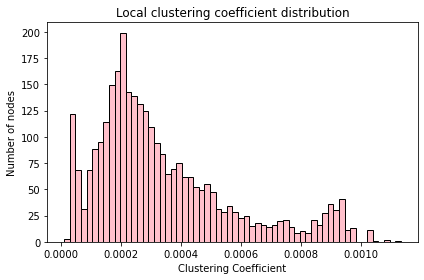

In [22]:
#1.10 Average and global clustering coefficient, Local clustering coefficient distribution for SNet
      
average_clustering_coefficient = nx.average_clustering(G)
global_clustering_coefficient = nx.transitivity(G)

subreddit, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())
local_clustering_data = [(subreddit, cc)  for subreddit, cc in zip(subreddit, clustering_coef) if cc > 0]
local_clustering_coefficients = pd.DataFrame(local_clustering_data, columns = ["subreddit", "cc"])
local_clustering_coefficients.sort_values('cc', inplace = True, ascending=False)

print("Average clustering coefficient : ", average_clustering_coefficient)
print("Global clustering coefficient : ", global_clustering_coefficient)
print("Local clustering coefficients\n", local_clustering_coefficients)

plt.hist(local_clustering_coefficients['cc'], color = 'pink', edgecolor = 'black',
         bins = int(300/5))

plt.title('Local clustering coefficient distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of nodes')
plt.tight_layout()
plt.show()


Average clustering coefficient :  0.025273234845362435
Global clustering coefficient :  0.025267744160115842
Local clustering coefficients
       subreddit        cc
1629       1629  0.037681
612         612  0.034369
1204       1204  0.033674
2484       2484  0.032864
359         359  0.032809
...         ...       ...
1032       1032  0.017593
2426       2426  0.017514
658         658  0.016963
1604       1604  0.016729
548         548  0.015066

[3524 rows x 2 columns]


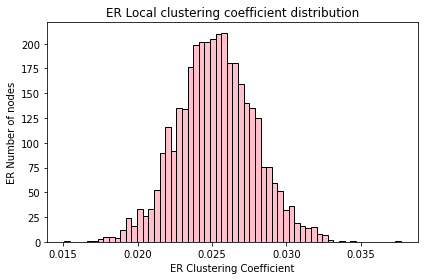

In [190]:
#1.10 Average and global clustering coefficient, Local clustering coefficient distribution for ER Net

average_clustering_coefficient_er = nx.average_clustering(er_net)
global_clustering_coefficient_er = nx.transitivity(er_net)


subreddit_er, clustering_coef_er = zip(*nx.clustering(er_net, weight = "weight").items())
local_clustering_data_er = [(subreddit, cc)  for subreddit, cc in zip(subreddit_er, clustering_coef_er) if cc > 0]
local_clustering_coefficients_er = pd.DataFrame(local_clustering_data_er, columns = ["subreddit", "cc"])
local_clustering_coefficients_er.sort_values('cc', inplace = True, ascending=False)

print("Average clustering coefficient : ", average_clustering_coefficient_er)
print("Global clustering coefficient : ", global_clustering_coefficient_er)
print("Local clustering coefficients\n", local_clustering_coefficients_er)

plt.hist(local_clustering_coefficients_er['cc'], color = 'pink', edgecolor = 'black',
         bins = int(300/5))

plt.title('ER Local clustering coefficient distribution')
plt.xlabel('ER Clustering Coefficient')
plt.ylabel('ER Number of nodes')
plt.tight_layout()
plt.show()

In [19]:
#1.12
# Assortativity for unweighted graph
r1 = nx.degree_assortativity_coefficient(G)
print(f"Assortativity coefficient for unweighted graph: {r1}")

# Assortativity for unweighted graph
#r2 = nx.degree_assortativity_coefficient(G, weight='weight') - couldn't run on local machine

Assortativity coefficient for unweighted graph: -0.43670253754011035


In [ ]:
#1.14

In [20]:
def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)       
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

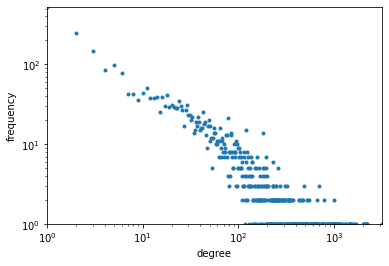

In [21]:
plot_deg_frequency(G)

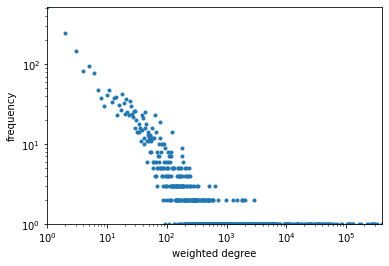

In [22]:
plot_deg_frequency(G, weighted = True)

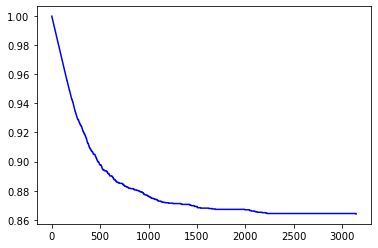

In [206]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

max_deg = max(deg)

# calculating histogram
values, base = np.histogram(deg, bins = max_deg)

# cumulative sum
cumulative = np.cumsum(values)

# Ploting complementary cumulative degree distribution P(X>x)
plt.plot(base[:-1], [float(x)/len(G) for x in len(G) - cumulative], c='blue')

plt.show()

In [200]:
results = powerlaw.Fit(degree_sequence)

print(results.supported_distributions)


Calculating best minimal value for power law fit
{'power_law': <class 'powerlaw.Power_Law'>, 'lognormal': <class 'powerlaw.Lognormal'>, 'exponential': <class 'powerlaw.Exponential'>, 'truncated_power_law': <class 'powerlaw.Truncated_Power_Law'>, 'stretched_exponential': <class 'powerlaw.Stretched_Exponential'>, 'lognormal_positive': <class 'powerlaw.Lognormal_Positive'>}


In [202]:
print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
R, p = results.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'exponential')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'truncated_power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")

2.2464911508648253
156.0
0.056025610831647574
Loglikelihood ratio: -12.644147229109814
Statistical significance: 0.001085624099228952
Loglikelihood ratio: 22.582676543743453
Statistical significance: 0.0730904396689174
Loglikelihood ratio: -15.613893371177623
Statistical significance: 2.2945806810170666e-08


Assuming nested distributions


In [23]:
#1.15 Hubs and authorities
hubs, authorities =nx.hits(G)

hub_items = sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("SNet Hubs\n")
for hub_item in hub_items:
    print(hub_item)

authority_items = sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("\nSNet Authorities\n")
for authority_item in authority_items:
    print(authority_item)

SNet Hubs

('reddit.com', 0.0634892676099054)
('politics', 0.052982234075869876)
('pics', 0.0494552512378013)
('funny', 0.04737307262556406)
('science', 0.04626831071461235)
('technology', 0.04472677605948191)
('worldnews', 0.043866658907851894)
('WTF', 0.043621869159447185)
('entertainment', 0.04186640209205595)
('programming', 0.037392328450102055)

SNet Authorities

('reddit.com', 0.06348926760990539)
('politics', 0.05298223407586986)
('pics', 0.0494552512378013)
('funny', 0.04737307262556407)
('science', 0.04626831071461234)
('technology', 0.044726776059481915)
('worldnews', 0.0438666589078519)
('WTF', 0.04362186915944719)
('entertainment', 0.04186640209205595)
('programming', 0.037392328450102076)


In [24]:
#Find core nodes

core_number = nx.core_number(G)
max_core_number = max(core_number.values())
print("Max core number : ", max_core_number)

    
#All hub/authorities are in core of network

Max core number :  192


In [227]:
#1.16 
#degree_centrality, closeness_centrality, betweenes_centrality
print("Top 10 Degree centrality:\n")
DC = nx.degree_centrality(G)
dc_items = sorted(DC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for dc_item in dc_items:
    print(dc_item[0], "\t\t",dc_item[1], "\t",G.degree[dc_item[0]])


Top 10 Degree centrality:
reddit.com 		 0.8921373829122906 	 3143
technology 		 0.6304286119784275 	 2221
politics 		 0.6275901220550667 	 2211
pics 		 0.6162361623616236 	 2171
funny 		 0.6026114107294919 	 2123
science 		 0.5975021288674425 	 2105
worldnews 		 0.5935282429747374 	 2091
entertainment 		 0.5850127732046551 	 2061
WTF 		 0.5801873403349418 	 2044
programming 		 0.5799034913426058 	 2043


In [26]:
print("Top 10 Closeness centrality:\n\n")
CC = nx.closeness_centrality(G)
cc_items = sorted(CC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for cc_item in cc_items:
    node = cc_item[0]
    print(cc_item[0], "   ", cc_item[1])

print("\nTop 10 Betweenness centrality:\n")
BC = nx.betweenness_centrality(G)
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for bc_item in bc_items:
    node = bc_item[0];
    print(bc_item[0], "   ", bc_item[1])


Top 10 Closeness centrality:


reddit.com     0.9019457245263697
technology     0.7283440148852595
politics     0.7260923330585326
pics     0.7201553556827474
funny     0.7125809061488673
science     0.710139084861923
worldnews     0.7084254976875126
entertainment     0.7040367705835332
WTF     0.7013736810670914
programming     0.700815595782773

Top 10 Betweenness centrality:

reddit.com     0.3686547520487645
technology     0.04937105642143906
programming     0.04363491513740279
politics     0.04304902436498485
business     0.04129223409955247
entertainment     0.03775667884001717
pics     0.03760614288944095
worldnews     0.03365842774623493
funny     0.032314804042720656
science     0.031917276291879515


In [229]:
#1.17 Eigenvector centrality

print("\nTop 10 Eigenvector centrality:\n")
EC = nx.eigenvector_centrality(G)
ec_items = sorted(EC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for ec_item in ec_items:
    print(ec_item[0], "   ", ec_item[1])



Top 10 Eigenvector centrality:

reddit.com     0.0869853759151425
politics     0.0849974875047629
technology     0.08495275088747631
pics     0.08488712702959006
science     0.0846269016537996
funny     0.08459504891566152
worldnews     0.08421867967487955
WTF     0.08368474037729566
entertainment     0.08336384940437629
programming     0.08281215543735897


In [3]:
#1.18 Katz centrality

def calculate_beta(default_beta, reddit_beta):
    dict = {}
    i = 0
    for node in G.nodes():
        if node == 'reddit.com':
            dict[node] = reddit_beta
        else:
            dict[node] = default_beta
        i+=1
        
    return dict


In [4]:
lambda_max =  max(nx.adjacency_spectrum(G))
print(1/lambda_max)

(5.451925984405687e-06+0j)


In [5]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight=None)
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.015273098900518325+0j)
technology     (0.01523503821027116+0j)
politics     (0.015234625345939582+0j)
pics     (0.015232974126722755+0j)
funny     (0.015230992597923642+0j)
science     (0.015230249630723917+0j)
worldnews     (0.015229671563045314+0j)
entertainment     (0.015228432969938055+0j)
WTF     (0.015227731246410805+0j)
programming     (0.015227689795011438+0j)


C:\Users\sretenp\Anaconda3\lib\site-packages\networkx\algorithms\centrality\katz.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  s = 1.0 / sqrt(sum(v ** 2 for v in x.values()))


In [6]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.04750841832002927+0j)
politics     (0.041888884286598135+0j)
pics     (0.0402947088873711+0j)
funny     (0.03923188438544093+0j)
science     (0.03875406522475151+0j)
technology     (0.03792700762289277+0j)
WTF     (0.037413989587874646+0j)
worldnews     (0.03741262673799614+0j)
entertainment     (0.036423310911065765+0j)
programming     (0.034095006170716556+0j)


In [10]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=calculate_beta(1,2), max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.06349001857351431+0j)
politics     (0.04387267950730567+0j)
pics     (0.042011669777274815+0j)
funny     (0.04085804970500777+0j)
science     (0.04033026330552025+0j)
technology     (0.03949476190703619+0j)
worldnews     (0.03890314148482572+0j)
WTF     (0.03887091569465365+0j)
entertainment     (0.03789771889121953+0j)
programming     (0.03537494299238236+0j)


In [9]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=calculate_beta(1,4), max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])

reddit.com     (0.060598214922778934+0j)
technology     (0.015208848474197666+0j)
politics     (0.015208436320273189+0j)
pics     (0.015206787940925493+0j)
funny     (0.01520480981947628+0j)
science     (0.01520406813014439+0j)
worldnews     (0.015203491056191636+0j)
entertainment     (0.015202254589924857+0j)
WTF     (0.015201554074713993+0j)
programming     (0.015201512682777819+0j)


In [ ]:
#1.20 Spektralna analiza
#Couldn't calculate because of complexity - 0(n^3)


In [25]:
#1.23
bridges = list(nx.bridges(G))
potential_brokers = []
for bridge in bridges:
    potential_brokers.append(bridge[0])
    potential_brokers.append(bridge[1])
print('Potential most influencial brokers: ',set(potential_brokers))

Potential most influencial brokers:  {'obama', 'love', 'Mustang', 'AquariumFish', 'MotherAboutInsane', 'SafetyNews', 'Rickey', 'HomeBrewNews', 'salakedan', 'Big_Tits_old_Milfs', 'Weblogicguru', 'Reefing', 'EstwingTools', 'testname', 'USMLEMD', 'sar', 'YouPublish', 'monika', 'mobwisdom', 'Hair', 'Soccymartin', 'Jawad', 'egistb', 'awwcute', 'exboyfriendback', 'Francie', 'ten31', 'PaulShort', 'elain', 'PoplarGirl1', 'psyapsy', 'bestshoes', 'Hindi', 'azher', 'xrosswheeler', 'wristtattoo', 'netaudio', 'zinio', 'fr', 'NuyoRiquena', 'The_Fantasy_Art_Blog', 'weddingfavors', 'TinT', 'umass', 'walmartvitamins', 'realsurf', 'mormon', 'nsedreams', 'sporevote', 'jenn', 'peaceulloan', 'civildraftinservice', 'PawShow', 'skytourbeau', 'Voto', 'rosilawani', 'Lipstick', 'Canuckgook', 'SpoonBlog', 'Tandberg', 'JamesButterfield', 'capetownnews', 'Zensurf', 'pycon2008', 'Victoria', 'DNChamp', 'Xstaticarmchair', 'Mickreddit', 'Shailendra', 'MontrealTechWatch', 'AtulTanna', 'gamereviews', 'Nima', 'GamingIndu

In [27]:
print('Most influencial brokers based on betweenes centrality')
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:]
for bc_item in bc_items:
    if bc_item[0] in set(potential_brokers) and bc_item[1]>0:
        print(bc_item[0], "   ", bc_item[1])

Most influencial brokers based on betweenes centrality
reddit.com     0.3686547520487645
technology     0.04937105642143906
programming     0.04363491513740279
politics     0.04304902436498485
business     0.04129223409955247
entertainment     0.03775667884001717
pics     0.03760614288944095
worldnews     0.03365842774623493
funny     0.032314804042720656
science     0.031917276291879515
WTF     0.02849546111627981
Chinese     0.014044014687369351
gaming     0.012221818395893997
Economics     0.010733825991583741
AskReddit     0.010028973351065664
nsfw     0.010000297129988444
environment     0.009430288969051627
atheism     0.008630839752859073
comics     0.007200097548767125
obama     0.005407476941709801
Health     0.004994144165884502
it     0.0044598562028012765
ads     0.004392895906832522
sports     0.0041240444080981545
es     0.004034831456892147
gossip     0.0032146865841833627
cogsci     0.0029586772426389357
de     0.0027909646564102768
Marijuana     0.002734033763997474
ma